In [1]:
!pip install keras==2.2.5
!apt-get install graphviz 
!pip install graphviz
!pip install git+https://github.com/waleedka/hiddenlayer.git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
  Cloning https://github.com/waleedka/hiddenlayer.git to /tmp/pip-req-build-rtlw4tlu
  Running command git clone -q https://github.com/waleedka/hiddenlayer.git /tmp/pip-req-build-rtlw4tlu
  Created wheel for hiddenlayer: filename=hiddenlayer-0.2-cp36-none-any.whl size=19746 sha256=e607497eec027e7863ea1da042675da065f8ed7420a0fdfa614a825214d86814
  Stored in directory: /tmp/pip-ephem-wheel-cache-dasch10_/wheels/49/bc/d1/938073704abdd049b3e4cdc6811c8f468d69fb5eecc6e01748
Successfully built hiddenlayer


In [0]:
#!rm -rf keras-neural-tensor-layer
#!&& git clone https://github.com/LanceNorskog/keras-neural-tensor-layer.git
#%cd keras-neural-tensor-layer

In [3]:
import math
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import hiddenlayer as hl
import hiddenlayer.transforms as ht

from google.colab import files

from keras import backend as K

from keras.optimizers import SGD, Adam
from keras.layers import Dense

from keras.layers import Input
from keras.models import Model
from keras.callbacks import EarlyStopping

#from ntn_diag import NeuralTensorDiagLayer

def get_data2(num_samples=100000):
  digits = load_digits()
  # create pairs of all images VS all images
  num_pairs = digits.data.shape[0] * digits.data.shape[0]
  pair1 = np.zeros((num_pairs), dtype='int32')
  pair2 = np.zeros((num_pairs), dtype='int32')
  #pair2 = [0] * num_pairs
  print(digits.data.shape[0])
  print(digits.data.shape[0] * digits.data.shape[0])
  k = 0
  # numpy.indices might do this but I can't figure it out!
  row, col = np.indices((digits.data.shape[0], digits.data.shape[0]))
  print('row.shape: ', row.shape)
  pair1 = row.reshape(num_pairs)
  pair2 = col.reshape(num_pairs)
  #for i in range(digits.data.shape[0]):
  #  for j in range(digits.data.shape[0]):
  #    pair1[k] = i
  #    pair2[k] = j
  #    k += 1
    
  # pick a random subset of image pairs
  subset = np.arange(num_pairs, dtype='int32')
  np.random.shuffle(subset)
  if num_samples < num_pairs:
    subset = subset[0:num_samples]
    print('subset: ', subset[0:20])
    pair1 = pair1[subset]
    pair2 = pair2[subset]
    num_pairs = num_samples

  print(pair1.shape)
  print(pair1[0:20])
  print(pair2[0:20])

  # calculate whether label of image is same, and if is lt
  left = digits.target[pair1]
  right = digits.target[pair2]
  print('left : ', left[0:20])
  print('right: ', right[0:20])
  eqall = np.asarray(left == right, dtype='float32')
  ltall = np.asarray(left < right, dtype='float32')
  print('eqall: ', eqall[0:20])
  print('ltall: ', ltall[0:20])

  # prepare actual images for input
  input1 = digits.data[pair1] / 16.0
  input2 = digits.data[pair2] / 16.0
  print(input1.shape)
  print(input2.shape)
    
  # prepare output of [eq, lt]
  output = np.zeros((num_pairs, 2))
  output = np.reshape(np.transpose([eqall, ltall], (1, 0)), (num_pairs, 2))
    
  print(output.shape)
  print(output[0:20])
 
  return input1, input2, output


def get_data():
  digits = load_digits()
  dig1 = []
  dig2 = []
  label = []
  for i in range(digits.data.shape[0]):
    for j in range(digits.data.shape[0]):
        #n = n + 1
        #if n % 50 == 0: 
            if digits.target[i] != digits.target[j]:
                dig1.append(digits.data[i])
                dig2.append(digits.data[j])
                if digits.target[i] > digits.target[j]:
                    label.append(1.0)
                else:
                    label.append(0.0)
  count = len(dig1)
  print('samples: ', count)
  (train_i, test_i, _, _) = train_test_split(np.arange(count, dtype='int32'), np.arange(count, dtype='int32'))
  print(train_i[0:10])
  print(test_i[0:10])
  dig1 = np.asarray(dig1, dtype='float32')/16.0
  dig2 = np.asarray(dig2, dtype='float32')/16.0
  label = np.asarray(label, dtype='float32')
  return dig1[train_i], dig2[train_i], label[train_i], dig1[test_i], dig2[test_i], label[test_i]

X1_train,X2_train,Y_train = get_data2(num_samples=100000)

print(X1_train[2])
print(X2_train[2])
print(Y_train[2])

Using TensorFlow backend.


1797
3229209
row.shape:  (1797, 1797)
subset:  [1574080  723949   78706 3020503 1977809 2917572  972177 1204009 2568481
 2065361 3114936 2478456 2485516 1951504  730493 2440181 3219356 2362938
  741290 2419662]
(100000,)
[ 875  402   43 1680 1100 1623  541  670 1429 1149 1733 1379 1383 1085
  406 1357 1791 1314  412 1346]
[1705 1555 1435 1543 1109 1041    0   19  568  608  735  393  265 1759
  911 1652  929 1680  926  900]
left :  [1 6 7 3 9 6 5 4 4 8 6 9 8 6 0 1 4 7 6 3]
right:  [8 0 0 9 6 2 0 9 7 9 3 7 9 9 6 4 4 3 1 4]
eqall:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
ltall:  [1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.]
(100000, 64)
(100000, 64)
(100000, 2)
[[0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]]
[0.     0.     0.     0.5625 0.9375 0.75   0.     0.     0.     0.
 0.25   0.4375 0.4375 0.875  0.     0.     0.  

In [0]:
from keras.engine.topology import Layer
import scipy.stats as stats

class NeuralTensorDiagLayer(Layer):
  def __init__(self, output_dim, input_dim=None, **kwargs):
    self.output_dim = output_dim #k
    self.input_dim = input_dim   #d
    if self.input_dim:
      kwargs['input_shape'] = (self.input_dim,)
    super(NeuralTensorDiagLayer, self).__init__(**kwargs)


  def build(self, input_shape):
    mean = 0.0
    std = 1.0
    # W : k*d
    k = self.output_dim
    d = self.input_dim
    initial_W_values = stats.truncnorm.rvs(-2 * std, 2 * std, loc=mean, scale=std, size=(k,d))
    initial_V_values = stats.truncnorm.rvs(-2 * std, 2 * std, loc=mean, scale=std, size=(2*d,k))
    self.W = K.variable(initial_W_values, name='W')
    self.V = K.variable(initial_V_values, name='V')
    self.b = K.zeros((self.input_dim * 2,), name='b')
    self.trainable_weights = [self.W, self.V, self.b]


  def call(self, inputs, mask=None):
    if type(inputs) is not list or len(inputs) != 2:
      raise Exception('NTNDiagLayer must be called on a list of tensors '
                      '(at least 2). Got: ' + str(inputs))
    e1 = inputs[0]
    e2 = inputs[1]
    #batch_size = K.shape(e1)[0]
    #print('batch_size: ', batch_size)
    k = self.output_dim
    #print('inputs: ', [e1,e2])
    feed_forward_product = K.dot(K.concatenate([e1,e2]) + self.b, self.V)
    #print('ff: ', feed_forward_product)
    #print('d1: ', e1 * self.W[0])
    #print('d2: ', e2 * (e1 * self.W[0]))
    #print('d3: ', e2 * (e1 * self.W[0]) + self.b)
    diag_tensor_products = [] 
    for i in range(k):
      diag_tensor_products.append(K.sum(e2 * (e1 * self.W[i])))
    #print('diag.shape: ', K.shape(diag_tensor_products[0]))
    #print('o1: ', K.stack(diag_tensor_products))
    #print('o2: ', K.reshape(K.concatenate(diag_tensor_products, axis=1), (batch_size, k)))
    #print('o3: ', K.reshape(K.concatenate(diag_tensor_products, axis=1), (-1, k)) + feed_forward_product)
    result = K.tanh(K.stack(diag_tensor_products) + feed_forward_product)
    #print('result: ', result)
    return result


  def compute_output_shape(self, input_shape):
    # print (input_shape)
    batch_size = input_shape[0][0]
    return (batch_size, self.output_dim)

In [5]:
!rm -f /tmp/filediag.pdf
squish=24
squish2=32

if True:
  input1 = Input(shape=(64,), dtype='float32')
  input2 = Input(shape=(64,), dtype='float32')
  i1 = Dense(units=squish, activation='relu')(input1)
  i2 = Dense(units=squish, activation='relu')(input2)
  btp = NeuralTensorDiagLayer(output_dim=squish2, input_dim=squish)([i1, i2])

  p = Dense(units=2, activation='sigmoid')(btp)
  model = Model(inputs=[input1, input2], outputs=[p])

  adam = Adam()
  model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['binary_accuracy'])
  model.summary()

  # Display graph view
  transforms = [
    # Build basic folds first
    # ht.Fold("Mul > Add > Sum", "MulAddSum"),
    # Display fully-connected layers differently
    ht.Prune("IsVariableInitialized"),
    # Fold repeated nodes
    ht.FoldDuplicates(),
  ]
  K.set_learning_phase(1)
  hl_graph = hl.build_graph(K.get_session().graph, transforms=transforms)
  hl_graph.theme = hl.graph.THEMES["blue"].copy()

  #print('graph: ', hl_graph)

  hl_graph.save('/tmp/filediag.pdf')  # Display graph view


  

W0901 02:46:48.967873 140377242236800 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0901 02:46:48.982784 140377242236800 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0901 02:46:48.990122 140377242236800 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0901 02:46:49.211176 140377242236800 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0901 02:46:49.221872 140377242236800 deprecation_wrappe

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 64)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 24)           1560        input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 24)           1560        input_2[0][0]                    
____________________________________________________________________________________________

In [6]:
!ls -l /tmp/file*.pdf
files.download('/tmp/filediag.pdf')

-rw-r--r-- 1 root root 35287 Sep  1 02:46 /tmp/filediag.pdf


MessageError: ignored

Train on 80000 samples, validate on 20000 samples
Epoch 1/50
 - 9s - loss: 0.4955 - binary_accuracy: 0.7475 - val_loss: 0.4140 - val_binary_accuracy: 0.8305
Epoch 2/50
 - 8s - loss: 0.3128 - binary_accuracy: 0.8803 - val_loss: 0.2467 - val_binary_accuracy: 0.9049
Epoch 3/50
 - 7s - loss: 0.2030 - binary_accuracy: 0.9193 - val_loss: 0.1663 - val_binary_accuracy: 0.9367
Epoch 4/50
 - 7s - loss: 0.1354 - binary_accuracy: 0.9488 - val_loss: 0.1093 - val_binary_accuracy: 0.9598
Epoch 5/50
 - 8s - loss: 0.0916 - binary_accuracy: 0.9681 - val_loss: 0.0795 - val_binary_accuracy: 0.9733
Epoch 6/50
 - 8s - loss: 0.0672 - binary_accuracy: 0.9779 - val_loss: 0.0576 - val_binary_accuracy: 0.9819
Epoch 7/50
 - 8s - loss: 0.0518 - binary_accuracy: 0.9835 - val_loss: 0.0495 - val_binary_accuracy: 0.9846
Epoch 8/50
 - 8s - loss: 0.0410 - binary_accuracy: 0.9870 - val_loss: 0.0405 - val_binary_accuracy: 0.9876
Epoch 9/50
 - 8s - loss: 0.0332 - binary_accuracy: 0.9898 - val_loss: 0.0357 - val_binary_accu

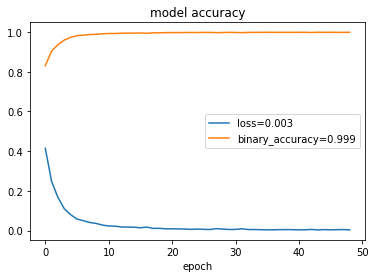

In [7]:
history = model.fit([X1_train, X2_train], Y_train, 
            validation_split=0.2,
            callbacks = [EarlyStopping(patience=5)],
            epochs=50, batch_size=32, verbose=2)

plt.figure()
metric_names = ['loss', 'binary_accuracy']
if history != None:
  # summarize history for accuracy
  for m in metric_names:
      #plt.plot(history.history[m])
      plt.plot(history.history['val_' + m])
  plt.title('model accuracy')
  plt.xlabel('epoch')
  sname = []
  for m in metric_names:
      sname.append('{}={:01.3f}'.format(m, history.history['val_' + m][-1]))
  plt.legend(sname, loc='center right')
  plt.show()